In [1]:
%matplotlib inline
import time
import numpy as np
from numpy import sqrt, cos, sin, pi
from numpy.fft import fft, ifft, rfft, irfft
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Generate data

In [10]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
nsamples_train = 10000
nsamples_test = 100
nsamples = nsamples_train + nsamples_test

In [4]:
# physics parameters that define the input (feature) and output (label)
n0 = 1.
vt = 1.
chi1 = 2. / sqrt(pi)

lx = 2. * pi
nx = 128
kmax = 8

In [5]:
def make_modes(x, kmax, magnitude=1.):
    """Make many sinusoidal modes with random amplitudes and phases.

    Args:
        x: 1d spatial coordinates.
        kmax: k = 1, 2, ..., kmax.

    Returns:
        modes: Superposition of all modes.
    """
    A = np.random.random((kmax)) * magnitude
    phi = np.random.random((kmax)) * pi * 2
    modes = np.zeros_like(x)
    for k in range(1, kmax):
        A_k = A[k]
        phi_k = phi[k]
        modes += A_k * np.cos(k * x + phi_k)
    return modes


def make_training_data():
    x = np.linspace(0, lx, nx)
    k = np.fft.fftfreq(nx, d=lx/nx) * 2. * pi

    T_all = []
    q_all = []

    coeff_q = -n0 * chi1 * sqrt(2) * vt * 1j * np.sign(k)

    for isample in tqdm(range(nsamples)):
        # Temperature flucutations in real space, T(x)
        T = make_modes(x, kmax)
        # Temperature fluctuations in Fourier spacer, T(k)
        Tk = fft(T)
        # heatflux fluctuation in Fourier space, q(k)
        qk = coeff_q * Tk
        # heatflux fluctuation in real space, q(x)
        q = ifft(qk).real

        # append real-space input/output of this sample
        T_all.append(T)
        q_all.append(q)

    # convert to ndarray of shape (nsamples, nx)
    T_all = np.array(T_all, dtype='f4')
    q_all = np.array(q_all, dtype='f4')

    return T_all, q_all


def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [6]:
T, q = make_training_data()

100%|██████████| 10100/10100 [00:01<00:00, 7143.42it/s]


In [7]:
T = normalize(T)
q = normalize(q)

In [8]:
train_inputs = torch.tensor(T[:nsamples_train, ...])
train_labels = torch.tensor(q[:nsamples_train, ...])

test_inputs  = torch.tensor(T[nsamples_train:, ...])
test_labels  = torch.tensor(q[nsamples_train:, ...])

In [12]:
# Create datasets and dataloaders

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset  = TensorDataset(test_inputs,  test_labels)

train_loader  = DataLoader(train_dataset, batch_size = 1024)
test_loader   = DataLoader(test_dataset , batch_size = 1024)

In [13]:
# init summary writer
import datetime
from torch.utils.tensorboard import SummaryWriter

start_time = datetime.datetime.now()
logdir     = "tensorboard_logs/"+start_time.strftime("%Y_%m_%d_%H_%M_%S")
writer     = SummaryWriter(logdir)

### Create the model

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # FIXME linear?
        return x


net = Net()
net.to(device) # move model onto the GPU (if available)
print(net)

Net(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
)


In [15]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

### Train the model

In [16]:
nepochs = 300
#batch_size = 25
#nbatches = train_inputs.shape[0] // batch_size

for epoch in range(nepochs):

    running_loss = 0.0
    #for i in range(nbatches):
        #inputs = train_inputs[i*batch_size:(i+1)*batch_size, ...]
        #labels = train_labels[i*batch_size:(i+1)*batch_size, ...]
    
    # iterate over every batch in the training data
    for i,(inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # print average batch loss, once per epoch
    print(f'epoch {epoch} loss: {running_loss/(i+1):e}')    
    writer.add_scalar("train_loss", loss.item())
    writer.flush()

    # todo: add a validation loop here
    
print('Finished Training')

epoch 0 loss: 1.748866e-01
epoch 1 loss: 1.716978e-01
epoch 2 loss: 1.684840e-01
epoch 3 loss: 1.648254e-01
epoch 4 loss: 1.604136e-01
epoch 5 loss: 1.550571e-01
epoch 6 loss: 1.486414e-01
epoch 7 loss: 1.410533e-01
epoch 8 loss: 1.321411e-01
epoch 9 loss: 1.217718e-01
epoch 10 loss: 1.098532e-01
epoch 11 loss: 9.637621e-02
epoch 12 loss: 8.149772e-02
epoch 13 loss: 6.572370e-02
epoch 14 loss: 5.032169e-02
epoch 15 loss: 3.756751e-02
epoch 16 loss: 2.921704e-02
epoch 17 loss: 2.439505e-02
epoch 18 loss: 2.152935e-02
epoch 19 loss: 1.971418e-02
epoch 20 loss: 1.830825e-02
epoch 21 loss: 1.715622e-02
epoch 22 loss: 1.620632e-02
epoch 23 loss: 1.540817e-02
epoch 24 loss: 1.472956e-02
epoch 25 loss: 1.414262e-02
epoch 26 loss: 1.362617e-02
epoch 27 loss: 1.316727e-02
epoch 28 loss: 1.275745e-02
epoch 29 loss: 1.238498e-02
epoch 30 loss: 1.204570e-02
epoch 31 loss: 1.173657e-02
epoch 32 loss: 1.145368e-02
epoch 33 loss: 1.119325e-02
epoch 34 loss: 1.095250e-02
epoch 35 loss: 1.073197e-02
ep

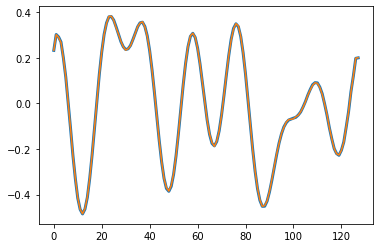

In [20]:
with torch.no_grad():  # test only, do not nudge the model
    inputs = test_inputs.to(device)
    test_labels_pred = net(inputs)
     
    for i in range(1):
        plt.plot(test_labels[0, ...],linewidth=3)
        plt.plot(test_labels_pred[0, ...].cpu())

In [ ]:
test_inputs.to('cuda')